<a href="https://colab.research.google.com/github/skj092/Real-vs-Fake-image/blob/main/Fake_Image_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading the Dataset

In [23]:
# %%bash
!mkdir ~/.kaggle

!chmod 600 /root/.kaggle/kaggle.json

!cp kaggle.json ~/.kaggle

!kaggle datasets download -d sophatvathana/casia-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
casia-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!unzip -q /content/casia-dataset.zip

## Fastai

In [14]:
# converting image to ela image
from glob import glob 
from tqdm import tqdm
from PIL import Image, ImageChops, ImageEnhance
import os 

def convert_to_ela_image(image_path, quality=90):
    """Converts an image to an ELA image.
    :param image_path: Path to the image
    :param quality: Quality of the image to be saved
    :return: ELA image
    """
    # Save the image at the given quality
    temp_file = 'temp.jpg'
    im = Image.open(image_path)
    im.save(temp_file, 'JPEG', quality=quality)

    # Open the saved image and the original image
    saved = Image.open(temp_file)
    orignal = Image.open(image_path)

    # Find the absolute difference between the images
    diff = ImageChops.difference(orignal, saved)

    # Normalize the difference by multiplying with a scale factor and convert to grayscale
    extrema = diff.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff
    diff = ImageEnhance.Brightness(diff).enhance(scale)

    # Remove the temporary file
    os.remove(temp_file)

    return diff

In [19]:
# all iamges
images = glob('/content/CASIA2/*/*.jpg')
print('Total images: ', len(images))

Total images:  9418


In [22]:
# converting images to ela images
for image in tqdm(images):
    # converting image to ela image
    ela_image = convert_to_ela_image(image)
    # creating a new directory for ela images
    if not os.path.exists('/content/CASIA2_ELA'):
      os.mkdir('/content/CASIA2_ELA')
    ela_image.save('/content/CASIA2_ELA/' + image.split('/')[-1])

100%|██████████| 9418/9418 [03:19<00:00, 47.12it/s]


In [23]:
# root directory
path = Path('/content/CASIA2_ELA')
Path.BASE_PATH = path
path.ls()

In [32]:
# function to get labels
def get_label(x): return x.name.split('_')[0]

# creating a datablock
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                        get_items=get_image_files,
                        splitter=RandomSplitter(valid_pct=0.2, seed=42),
                        get_y=get_label,
                        item_tfms=Resize(224))
                    
# creating a dataloader
dls = dblock.dataloaders(path)

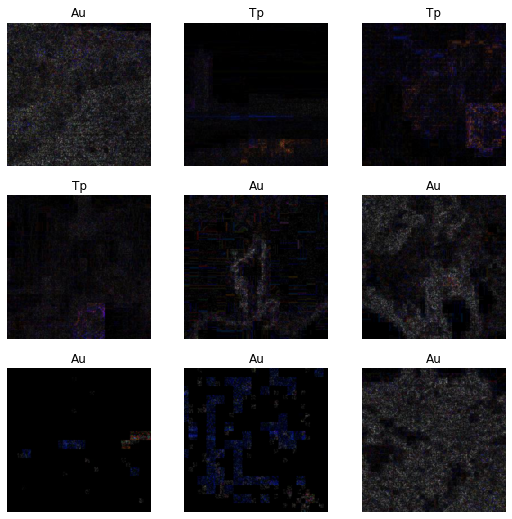

In [33]:
dls.show_batch()

In [ ]:
!pip install wandb

import wandb
wandb.login()

In [38]:
# start logging a wandb run
wandb.init(project='RealvsFake Image')
import wandb
from fastai.callback.wandb import *

wandb: Currently logged in as: skj092. Use `wandb login --relogin` to force relogin


In [39]:
# creating a cnn learner
learn = vision_learner(dls, resnet18, metrics=accuracy, cbs=WandbCallback())

learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.542436,0.325888,0.883782,00:45


epoch,train_loss,valid_loss,accuracy,time
0,0.264876,0.184828,0.929741,00:47
1,0.180488,0.160633,0.939250,00:48
2,0.121494,0.142663,0.948759,00:47
3,0.080628,0.127545,0.952456,00:47


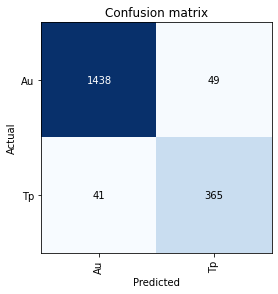

In [40]:
# Evaluation 
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()